<a href="https://colab.research.google.com/github/seyeon0815/Project/blob/main/%ED%98%BC%EA%B3%B5%EB%A8%B8%EC%8B%A0_ch08_01%2C02%2C03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 패션 MNIST 데이터 불러오기
- 운동화,셔츠,샌들 등 작은 이미지들의 모음, 28x28 픽셀 이미지 70000개
- 데이터 스케일을 0~255사이 0~1로 표준화
- 훈련 데이터/ 검증 데이터 분류
- 완전 연결 신경망(Fully Connected Layer)
- 2차원 배열 -> 1차원 배열로 만들어 줘야 함

In [ ]:
from tensorflow import keras
from sklearn.model_selection import train_test_split

(train_input, train_target), (test_input, test_target) = \
    keras.datasets.fashion_mnist.load_data()

train_scaled = train_input.reshape(-1, 28, 28, 1) / 255.0 #(48000,28,28)크기.3차원 배열인 train_input이 (48000,28,28,1)크기, 4차원 배열인 train_scaled가 됨

train_scaled, val_scaled, train_target, val_target = train_test_split(
    train_scaled, train_target, test_size=0.2, random_state=42)

4431872/4422102 [==============================] - 0s 0us/step


# 합성곱 신경망 만들기
- 합성곱 층으로 이미지에서 특징을 감지 -> 밀집층으로 클래스에 따른 분류 확률 계산

In [ ]:
model = keras.Sequential()
#Conv : 합성곱 층 만들기
model.add(keras.layers.Conv2D(32, kernel_size=3, activation='relu',padding='same',input_shape=(28,28,1))) #32개의 필터 사용-> 특성맵의 깊이=32/커널 크기(3,3): 가로세로 크기 같으면 정수 하나로 지정
model.add(keras.layers.MaxPooling2D(2))

# 풀링층 만들기
model.add(keras.layers.MaxPooling2D(2)) #(2,2)풀링적용 ->특성맵 크기 절반으로 줄어듬 -> (14,14,32)

# 합성곱 층
model.add(keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu', # 필터 개수만 64개로 늘림
                              padding='same'))
#  풀링층
model.add(keras.layers.MaxPooling2D(2)) #(2,2)풀링적용 ->특성맵 크기 절반으로 줄어듬 -> (7,7,64)

#완전연결층(밀집층 =  Fully connected Layer)
model.add(keras.layers.Flatten()) # 3차원 특성맵을 1차원으로 만들기(마지막에 10개 뉴런을 가진 밀집 출력층에서 확률 계산하기 때문)
model.add(keras.layers.Dense(100, activation='relu')) #Dense 은닉층, 100개의 뉴런 사용
model.add(keras.layers.Dropout(0.4)) #Dropout층이 은닉층의 과대적합을 막아줌
model.add(keras.layers.Dense(10, activation='softmax')) #Dense 출력층,softmax함수 사용(클래스 10개를 분류하는 다중분류 문제이기 때문)
                    

In [ ]:
model.summary() 
#깊이가 깊어질수록(채널 늘어날수록) total params(연산개수)가 늘어남,연산시간 늘어남 -> 일정 시점에서 정확도 증가x
#이미지의 특성 확인 상세하게 -> 채널 수 늘리기 (작은 이미지씩 보기)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 3, 3, 64)         0         
 2D)                                                             
                                                        

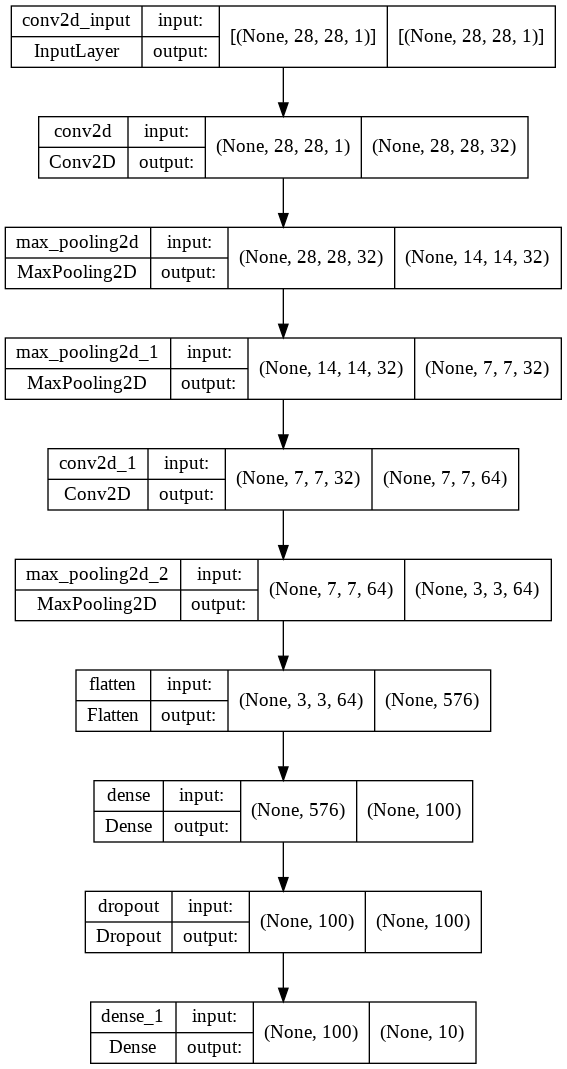

In [ ]:
keras.utils.plot_model(model, show_shapes = True) #plot_model():층의 구성을 그림으로 표현 / show_shapes = True: 그림에 입력과 출력의 크기 표시

- 위에까지 한 것은 모델 정의
- 모델 컴파일 후 훈련

In [ ]:
import tensorflow as tf
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', 
              metrics='accuracy')
#optimizer:최적화(최소 cost로 결과 찾기)- adam:방향,스텝 사이즈 적절하게
# 손실함수(=비용(cost)함수) :특정 알고리즘이 주어진 데이터를 얼마나 잘 모델링하는지를 측정하는 방법/학습모델을 사용해 예측한 값이 참 값과 차이가 많이 날 경우 손실함수의 값은 매우 커지게 되며, 손실함수 값이 작을 수록 알고리즘이 주어진 데이터를 잘 모델링했다고 평가
#sparse_categorical_crossentropy : 다중분류에서 사용하는 손실함수

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-cnn-model.h5', # ModelCheckpoint: 모델 저장
                                                save_best_only=True) #save_best_only: True ->monitor(기준값)되고 있는 값을 기준으로 가장 좋은 값으로 모델 저장,False의 경우 매 에폭마다 모델 저장(model0,model1,model2,,,)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2, #EarlyStopping: model의 성능 지표가 설정한 epoch동안 개선되지 않을 때 조기 종료(과적합 방지)/ #patience: 더이상 개선이 없을 경우 몇번의 epoch를 더 진행할지
                                                  #baseline: 달성해야 할 최소한의 기준값
                                                  restore_best_weights=True) # 관찰하는 수량의 최선값이 발생한 세대에서 모델 가중치를 복원할지(True:학습이 끝난 뒤 가장 좋았던 값으로 가중치 복원/ False: 학습 마지막 단계에서 얻어진 모델 가중치 사용)

with tf.device('/device:GPU:0'): #텐서플로우를 gpu에 할당
  history = model.fit(train_scaled, train_target, epochs=10,
                      validation_data=(val_scaled, val_target),
                      callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/10
1500/1500 [==============================] - 20s 6ms/step - loss: 0.6382 - accuracy: 0.7669 - val_loss: 0.3944 - val_accuracy: 0.8626
Epoch 2/10
1500/1500 [==============================] - 9s 6ms/step - loss: 0.4089 - accuracy: 0.8529 - val_loss: 0.3250 - val_accuracy: 0.8823
Epoch 3/10
1500/1500 [==============================] - 8s 5ms/step - loss: 0.3492 - accuracy: 0.8758 - val_loss: 0.2984 - val_accuracy: 0.8891
Epoch 4/10
1500/1500 [==============================] - 8s 5ms/step - loss: 0.3175 - accuracy: 0.8864 - val_loss: 0.2741 - val_accuracy: 0.8974
Epoch 5/10
1500/1500 [==============================] - 8s 5ms/step - loss: 0.2917 - accuracy: 0.8936 - val_loss: 0.2724 - val_accuracy: 0.9029
Epoch 6/10
1500/1500 [==============================] - 8s 5ms/step - loss: 0.2741 - accuracy: 0.9004 - val_loss: 0.2590 - val_accuracy: 0.9051
Epoch 7/10
1500/1500 [==============================] - 8s 5ms/step - loss: 0.2586 - accuracy: 0.9062 - val_loss: 0.2541 - val_accuracy

- 모델 학습 곡선 그리기

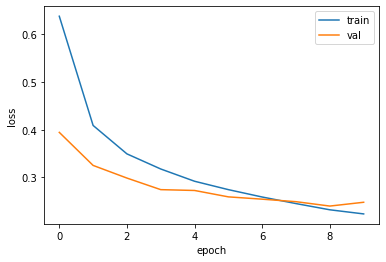

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

# 합성곱 신경망 시각화
- p.465

In [ ]:
from tensorflow import keras
# 사전학습 진행
model = keras.models.load_model("best-cnn-model.h5")

# keras.utils.plot_model(model, show_shapes = True)
model.layers

- 합성곱 층의 가중치를 확인 가능

In [ ]:
conv = model.layers[0]
print(conv.weights[0].shape, conv.weights[1].shape)

(3, 3, 1, 32) (32,)


In [ ]:
conv_weights = conv.weights[0].numpy()
print(conv_weights.mean(), conv_weights.std()) #평균, 표준편차

-0.043679073 0.32953104


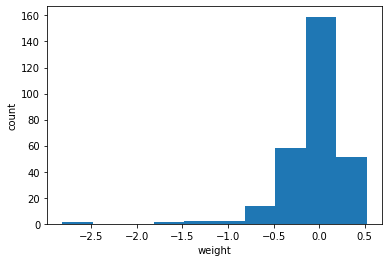

In [ ]:
plt.hist(conv_weights.reshape(-1,1))
plt.xlabel('weight')
plt.ylabel('count')
plt.show()

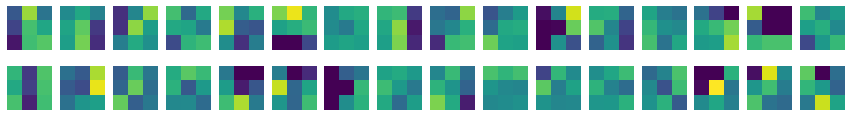

In [ ]:
fig, axs = plt.subplots(2, 16, figsize=(15,2))

for i in range(2):
    for j in range(16):
        axs[i, j].imshow(conv_weights[:,:,0,i*16 + j], vmin=-0.5, vmax=0.5)
        axs[i, j].axis('off')

plt.show()
    #어두운 부분:값이 없다,밝은 부분:값이 적다

In [ ]:
no_training_model = keras.Sequential()

no_training_model.add(keras.layers.Conv2D(32, kernel_size=3,activation='relu',padding='same', input_shape=(28,28,1)))

In [ ]:
no_training_conv = no_training_model.layers[0]

print(no_training_conv.weights[0].shape)

(3, 3, 1, 32)


In [ ]:
no_training_weights = no_training_conv.weights[0].numpy()
print(no_training_weights.mean(), no_training_weights.std())

0.001661575 0.07862841


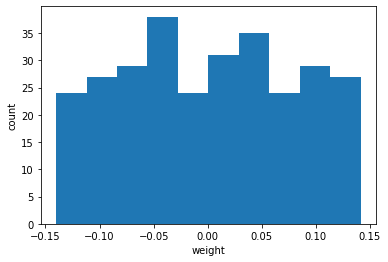

In [ ]:
plt.hist(no_training_weights.reshape(-1,1))
plt.xlabel('weight')
plt.ylabel('count')
plt.show()

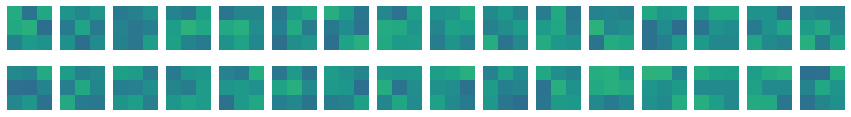

In [ ]:
fig, axs = plt.subplots(2, 16, figsize=(15,2))

for i in range(2):
    for j in range(16):
        axs[i, j].imshow(no_training_weights[:,:,0,i*16 + j], vmin=-0.5, vmax=0.5)
        axs[i, j].axis('off')

plt.show()
# 어두운 부분이 없다 ->

# 함수형 API
- p.474

KerasTensor(type_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='conv2d_input'), name='conv2d_input', description="created by layer 'conv2d_input'")


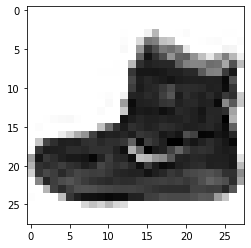

In [ ]:
print(model.input)
conv_acti = keras.Model(model.input, model.layers[0].output)
(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()
plt.imshow(train_input[0], cmap='gray_r')
plt.show()

In [ ]:
inputs = train_input[0:1].reshape(-1, 28, 28, 1)/255.0
feature_maps = conv_acti.predict(inputs)
print(feature_maps.shape)

(1, 28, 28, 32)


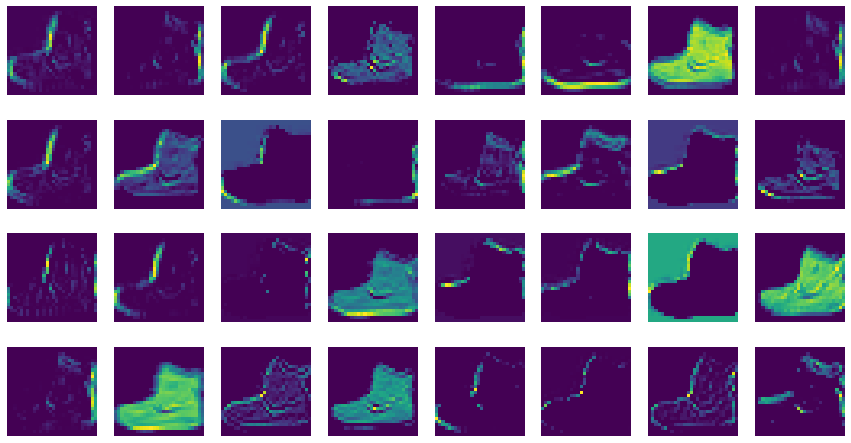

In [ ]:
fig, axs = plt.subplots(4, 8, figsize=(15,8))

for i in range(4):
    for j in range(8):
        axs[i, j].imshow(feature_maps[0,:,:,i*8 + j])
        axs[i, j].axis('off')

plt.show()

(1, 7, 7, 32)


IndexError: ignored

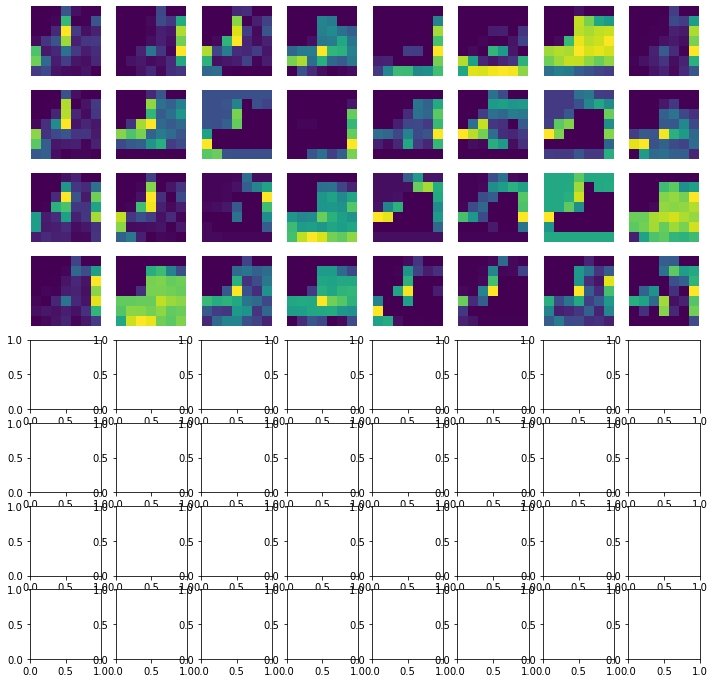

In [ ]:
conv2_acti = keras.Model(model.input, model.layers[2].output)
feature_maps = conv2_acti.predict(train_input[0:1].reshape(-1, 28, 28, 1)/255.0)
print(feature_maps.shape)

fig, axs = plt.subplots(8, 8, figsize=(12,12))

for i in range(8):
    for j in range(8):
        axs[i, j].imshow(feature_maps[0,:,:,i*8 + j])
        axs[i, j].axis('off')

plt.show()